# Identifying stations outside the country boundaries in OSCAR
In OSCAR/Surface the country of a station is an attribute that is independent of the station location. Therefore it is in theory possible to put a station outside the boundaries of the country. This notebook identifies such stations. It uses online data retrieved from APIs so that is can be run again at any future point in time 

In [1]:
# first we import the libraries we will be working with 
import requests 
import json
import urllib.parse
from urllib.parse import quote
import geopandas as gpd
import pandas as pd
from io import StringIO
from shapely.geometry import Point

In [122]:
# quote URL parameters, OSCAR/Surface style
def oscarQuote(params):
    ret=[]
    for key, value in params.items():
        if isinstance(value,list):
            mykey = urllib.parse.quote(key)
            values = [urllib.parse.quote(v) for v in value]
            myvalue = ",".join(values)
        else:
            mykey=urllib.parse.quote(key)
            myvalue=urllib.parse.quote(value)
            
        ret.append("{}={}".format(mykey,myvalue))

    return "&".join(ret)

Get the list of WMO countries  

In [3]:
with urllib.request.urlopen("https://www.wmo.int/cpdb/data/membersandterritories.json") as url:
    wmo_members = json.loads(url.read().decode())

Get stations country by country from OSCAR/Surface using new API

In [47]:
gdf_stations = gpd.GeoDataFrame()
c=0
for iso3,country in wmo_members["countries"].items():
    #if (c==3):
    #    continue
    c=c+1
    # https://oscar.wmo.int/surface/rest/api/search/station?territoryName=DEU&facilityType=lakeRiverFixed,lakeRiverMobile,landFixed,landMobile,landOnIce
    params = {
        'territoryName' : iso3,
        'facilityType' : ['lakeRiverFixed','lakeRiverMobile','landFixed','landMobile','landOnIce']
    }

    param = oscarQuote(params)
    url = "https://oscar.wmo.int/surface/rest/api/search/station?{}".format(param)
    print("getting data for {}".format(iso3))
    try:
        df_stations = pd.read_json(url)
    
        if (len(df_stations)==0):
            continue

        geometry = [Point(xy) for xy in zip(df_stations.longitude, df_stations.latitude)]
        df_stations = df_stations.drop(['longitude', 'latitude'], axis=1)
        crs = {'init': 'epsg:4326'}
        df_stations["station_iso3"] = iso3
        gdf_stations = pd.concat( [ gdf_stations, gpd.GeoDataFrame(df_stations, crs=crs, geometry=geometry) ] )

    except Exception:
        print("error with {}, skipping".format(iso3))



getting data for AFG
getting data for ALB
getting data for DZA
getting data for AGO
getting data for ATG
getting data for ARG
getting data for ARM
getting data for AUS
getting data for AUT
getting data for AZE
getting data for BHS
getting data for BHR
getting data for BGD
getting data for BRB
getting data for BLR
getting data for BEL
getting data for BLZ
getting data for BEN
getting data for BTN
getting data for BOL
getting data for BIH
getting data for BWA
getting data for BRA
getting data for BCT
getting data for BRN
getting data for BGR
getting data for BFA
getting data for BDI
getting data for CPV
getting data for KHM
getting data for CMR
getting data for CAN
getting data for CAF
getting data for TCD
getting data for CHL
getting data for CHN
getting data for COL
getting data for COM
getting data for COG
getting data for COK
getting data for CRI
getting data for CIV
getting data for HRV
getting data for CUB
getting data for CSM
error with CSM, skipping
getting data for CYP
getting d

In [53]:
# get WMO basemap for boundaries
url_basemap = 'https://www.wmo.int/cpdb/js/json/WMO_basemap.json'
gdf_countries = gpd.read_file (url_basemap)


In [124]:
# spatial join of stations and country polygons
gdf_join = gpd.sjoin( gdf_countries, gdf_stations , how="inner", op='contains' )
temp = gdf_join[ gdf_join["POL_C_CODE"] != gdf_join["station_iso3"] ][["id","POL_C_CODE"]]
stations_outside_country = gdf_stations.join( temp.set_index('id') , how='inner', on='id'  )

C:\Users\Timo\Anaconda3\envs\workenv\lib\site-packages\numpy\lib\function_base.py:2810: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


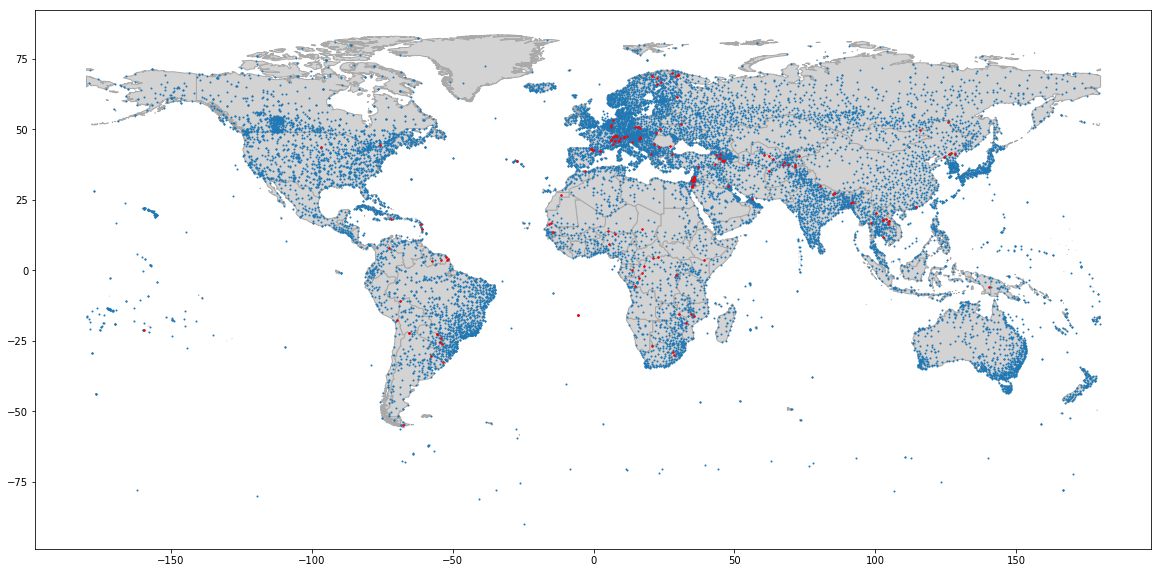

In [125]:
%matplotlib inline
ax=gdf_countries.plot( edgecolor='darkgrey', color='lightgrey' , figsize=(20,12))
gdf_stations.plot(ax=ax,markersize=1)
stations_outside_country.plot(ax=ax,color="red",markersize=2)

In [119]:
stations_outside_country[["id","name","station_iso3","stationTypeName","wmoIndex","POL_C_CODE"]].rename(
    columns={'POL_C_CODE':'physical_country_iso3','station_iso3':'stated_country_iso3'})

,id,name,stated_country_iso3,stationTypeName,wmoIndex,physical_country_iso3
12,6083,HAIRATAN,AFG,Land (fixed),0-20000-0-40916,UZB
39,6086,TURGHUNDI,AFG,Land (fixed),0-20000-0-40921,TKM
7,12378,B.DE IRIGOYEN AERO,ARG,Land (fixed),0-20000-0-87163,BRA
46,12365,LA QUIACA OBSERVATORIO,ARG,Land (fixed),0-20000-0-87007,BOL
51,603,La Quiaca Observatorio,ARG,Land (fixed),0-20008-0-LQO,BOL
58,12404,MONTE CASEROS AERO,ARG,Land (fixed),0-20000-0-87393,URY
6,5617,ARARAT,ARM,Land (fixed),0-20000-0-37874,TUR
7,5618,ARENI,ARM,Land (fixed),0-20000-0-37875,AZE
14,5539,BAGRATASHEN,ARM,Land (fixed),0-20000-0-37626,GEO
26,5647,KAPAN,ARM,Land (fixed),0-20000-0-37959,AZE
